In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from pandas_ml import ConfusionMatrix

import networkx as nx
from networkx.algorithms import bipartite
from networkx.algorithms.matching import max_weight_matching

pd.options.mode.chained_assignment = None

# 04 - Applied ML
## Question 1: Propensity score matching
### 0. Loading the dataset




In [2]:
lalonde_df = pd.read_csv('./lalonde.csv')
lalonde_df.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


### 1. A naive analysis

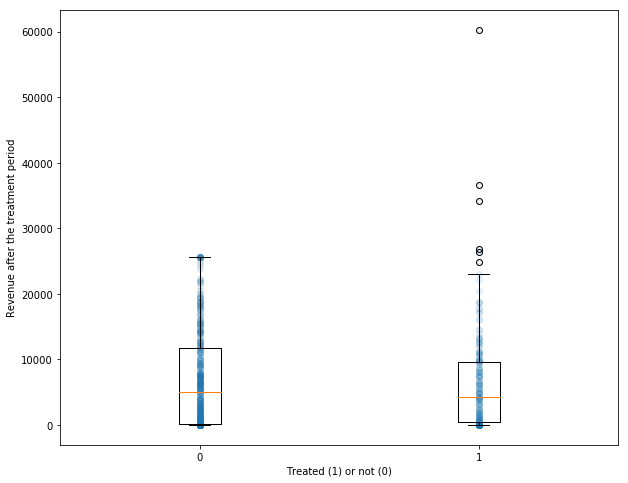

In [3]:
plt.figure(figsize=(10, 8))
plt.scatter(lalonde_df.treat, lalonde_df.re78, alpha=0.1)

plt.xlabel('Treated (1) or not (0)')
plt.ylabel('Revenue after the treatment period')

treated_df = lalonde_df[lalonde_df.treat == 1]
control_df = lalonde_df[lalonde_df.treat == 0]

plt.boxplot([control_df.re78, treated_df.re78], positions=[0, 1]);

In [269]:
# Calculation of the evolution of the salaries to outline correlations between salary and treatment
lalonde_df['salary_evol74'] = lalonde_df.re78 - lalonde_df.re74
lalonde_df['salary_evol75'] = lalonde_df.re78 - lalonde_df.re75
lalonde_df.corr()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,salary_evol74,salary_evol75
treat,1.000000,-0.102893,0.019308,0.600907,-0.117983,-0.301334,0.105857,-0.249779,-0.130197,-0.039033,0.165116,0.018712
age,-0.102893,1.000000,-0.125622,-0.110730,-0.053400,0.376059,-0.069218,0.333254,0.140022,0.106249,-0.169921,0.045225
educ,0.019308,-0.125622,1.000000,-0.010528,-0.174153,-0.095051,-0.701452,0.136583,0.018301,0.161538,0.040086,0.156039
black,0.600907,-0.110730,-0.010528,1.000000,-0.294973,-0.317118,0.109278,-0.257334,-0.140374,-0.120977,0.095005,-0.060042
hispan,-0.117983,-0.053400,-0.174153,-0.294973,1.000000,0.021549,0.100869,-0.007091,0.061589,0.015325,0.019969,-0.012044
married,-0.301334,0.376059,-0.095051,-0.317118,0.021549,1.000000,-0.032349,0.425739,0.353824,0.162358,-0.192320,0.006375
nodegree,0.105857,-0.069218,-0.701452,0.109278,0.100869,-0.032349,1.000000,-0.208751,-0.070412,-0.142418,0.035890,-0.113224
re74,-0.249779,0.333254,0.136583,-0.257334,-0.007091,0.425739,-0.208751,1.000000,0.552002,0.343416,-0.487013,0.101578
re75,-0.130197,0.140022,0.018301,-0.140374,0.061589,0.353824,-0.070412,0.552002,1.000000,0.257659,-0.205509,-0.186564
re78,-0.039033,0.106249,0.161538,-0.120977,0.015325,0.162358,-0.142418,0.343416,0.257659,1.000000,0.653030,0.901202


**Naive interpretation:**
The correlation between treatment and revenue after treatment very low. The median is also quite similar between the two groups, with more extreme values (first quartile is 50% lower and last quartile is 18% higher). So the treatment seems to have no effect to the outcome, or may decrease inequalities of salaries. However and considering the low correlation, it is impossible to be categorical.

We can also see there is a low correlation level between salary evolution before treatment and after (0.165).

The descriptive analysis the the above plot outlines some outlier in the treated group with very high salaries.

### 2. A closer look at the data

In [270]:
treated_df.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,185.0,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,1.0,25.816216,10.345946,0.843243,0.059459,0.189189,0.708108,2095.573689,1532.055314,6349.143530
std,0.0,7.155019,2.010650,0.364558,0.237124,0.392722,0.455867,4886.620353,3219.250870,7867.402218
min,1.0,17.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,20.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,485.229800
50%,1.0,25.000000,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4232.309000
75%,1.0,29.000000,12.000000,1.000000,0.000000,0.000000,1.000000,1291.468000,1817.284000,9642.999000
max,1.0,48.000000,16.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


In [271]:
control_df.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,429.0,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000
mean,0.0,28.030303,10.235431,0.202797,0.142191,0.512821,0.596737,5619.236506,2466.484443,6984.169742
std,0.0,10.786653,2.855238,0.402552,0.349654,0.500419,0.491126,6788.750796,3291.996183,7294.161791
min,0.0,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,19.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,220.181300
50%,0.0,25.000000,11.000000,0.000000,0.000000,1.000000,1.000000,2547.047000,1086.726000,4975.505000
75%,0.0,35.000000,12.000000,0.000000,0.000000,1.000000,1.000000,9277.128000,3881.419000,11688.820000
max,0.0,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,25862.320000,18347.230000,25564.670000


In [272]:
print('Control: ' + str(control_df.re74[control_df.re74 == 0].count() / control_df.re74.count()))
print('Treated: ' + str(treated_df.re74[treated_df.re74 == 0].count() / treated_df.re74.count()))

Control: 0.261072261072
Treated: 0.708108108108


There is twice more people in the control group than in the treated one. This reduces confidence in the data.

Treated group contains more black people (84%) than the the control group (only 20%). Furthermore, the ratio of married people in the treated group is less than the control group (19% against 51%). Moreover, the distribution of salaries is not fair between the two groups in 1974-1975 (26% of the people did not have a salary vs 70% for the treated group). Despite having more or less the same years of education distribution, the treated group has more no degree than the control one (70% vs 60%).

The treated group has also more young people (we can compare the third quartile of the two groups and see the difference: 29 years old vs 35 years old).

This outlines the fact that these two groups may have not been established on the same criteria.

The following chart describes the repartition of age between the two groups:

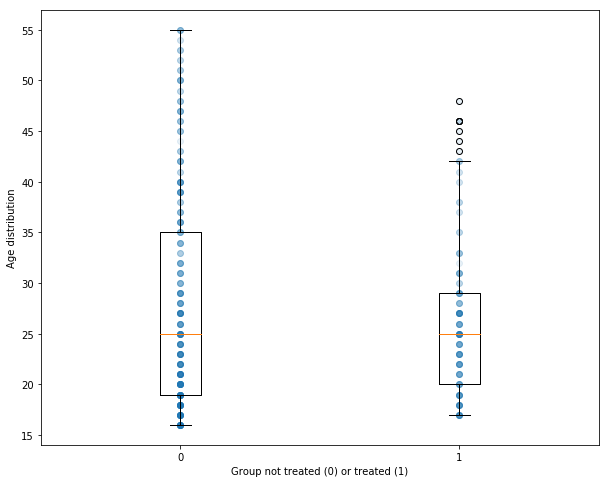

In [273]:
plt.figure(figsize=(10, 8))
plt.scatter(lalonde_df.treat, lalonde_df.age, alpha=0.1)

plt.xlabel('Group not treated (0) or treated (1)')
plt.ylabel('Age distribution')

treated_df = lalonde_df[lalonde_df.treat == 1]
control_df = lalonde_df[lalonde_df.treat == 0]

plt.boxplot([control_df.age, treated_df.age], positions=[0, 1]);

The following chart describes the initial revenue distribution between the two groups:

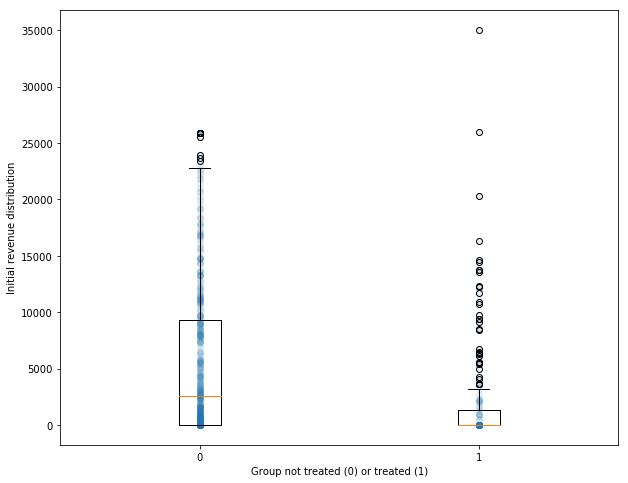

In [274]:
plt.figure(figsize=(10, 8))
plt.scatter(lalonde_df.treat, lalonde_df.re74, alpha=0.1)

plt.xlabel('Group not treated (0) or treated (1)')
plt.ylabel('Initial revenue distribution')

treated_df = lalonde_df[lalonde_df.treat == 1]
control_df = lalonde_df[lalonde_df.treat == 0]

plt.boxplot([control_df.re74, treated_df.re74], positions=[0, 1]);

As the two groups don't come from the same distribution, the naive interpretation based on the descriptive analysis is not sufficient.

### 3. A propensity score model

We calculate the propensity score which is the probability of receiving the treatment, based on the pre-treatment features. We drop the features *treat*, *id* and *re78*.

For that, we will use logistic regression. We first train the classifier.

In [275]:
from sklearn import linear_model

logistic = linear_model.LogisticRegression()

y = lalonde_df.treat
x = lalonde_df.drop(['treat', 'id', 're78'], axis=1)

logistic.fit(x, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Then we use it to calculate the propensity score, which is the probability of being treated predicted by the classifier. We add this information to the Dataframe.

In [276]:
proba = logistic.predict_proba(x)
propensity_score = proba[:, 1]

propensity_score_series = pd.Series(propensity_score)
propensity_df = lalonde_df.assign(propensity_score=propensity_score_series.values)
propensity_df.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,salary_evol74,salary_evol75,propensity_score
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,9930.0460,9930.0460,0.458039
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,3595.8940,3595.8940,0.152098
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,24909.4500,24909.4500,0.750804
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,7506.1460,7506.1460,0.673895
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,289.7899,289.7899,0.670458


### 4. Balancing the dataset via matching

#### Matching

We want to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group. 

Do do that, we firstly seperate the data in two, one for the treated and one for the control:

In [277]:
treated_df = propensity_df[propensity_df.treat == 1]
control_df = propensity_df[propensity_df.treat == 0]

We then create a bipartite graph using these two groups:

In [278]:
B = nx.Graph()

B.add_nodes_from(control_df.id.values, bipartite=0)
B.add_nodes_from(treated_df.id.values, bipartite=1)

For the edges, we need to compute the difference of the propensity score for each pair.  
The weight is the negative absolute difference as the function we will use is the maximum matching.

In [279]:
edges = []
for treated_index, treated in treated_df.iterrows():
    for control_index, control in control_df.iterrows():
        edges.append((treated.id, control.id, -abs(treated.propensity_score - control.propensity_score)))

B.add_weighted_edges_from(edges)

We then call the magic function from networkx package that will do the maximum matching.

In [280]:
matching_result = max_weight_matching(B, True)

# Printing the 10 first matches
[(k,v) for k,v in matching_result.items()][:10]

[('PSID131', 'NSW63'),
 ('NSW21', 'PSID425'),
 ('PSID153', 'NSW13'),
 ('PSID173', 'NSW18'),
 ('PSID289', 'NSW178'),
 ('NSW62', 'PSID180'),
 ('NSW88', 'PSID392'),
 ('NSW112', 'PSID383'),
 ('PSID6', 'NSW46'),
 ('PSID385', 'NSW27')]

We can now filter our dataframe with only the matched elements:

In [281]:
matched_list = list(matching_result.keys())
matched_df = propensity_df[propensity_df.id.isin(matched_list)]
matched_df.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,salary_evol74,salary_evol75,propensity_score
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,9930.0460,9930.0460,0.458039
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,3595.8940,3595.8940,0.152098
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,24909.4500,24909.4500,0.750804
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,7506.1460,7506.1460,0.673895
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,289.7899,289.7899,0.670458


#### Distribution comparison

In [282]:
treated_df = matched_df[matched_df.treat == 1]
control_df = matched_df[matched_df.treat == 0]

In [290]:
treated_df.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,salary_evol74,salary_evol75,propensity_score
count,185.0,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,1.0,25.816216,10.345946,0.843243,0.059459,0.189189,0.708108,2095.573689,1532.055314,6349.143530,4253.569842,4817.088216,0.555368
std,0.0,7.155019,2.010650,0.364558,0.237124,0.392722,0.455867,4886.620353,3219.250870,7867.402218,8926.985184,8275.409427,0.206391
min,1.0,17.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-25256.802700,-20960.298000,0.036216
25%,1.0,20.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,485.229800,0.000000,0.000000,0.451793
50%,1.0,25.000000,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4232.309000,2456.153000,2787.960000,0.647608
75%,1.0,29.000000,12.000000,1.000000,0.000000,0.000000,1.000000,1291.468000,1817.284000,9642.999000,8173.908000,8087.487000,0.695705
max,1.0,48.000000,16.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000,60307.930000,59023.851000,0.885477


In [285]:
control_df.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,salary_evol74,salary_evol75,propensity_score
count,185.0,185.000000,185.000000,185.00000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,0.0,23.167568,9.864865,0.47027,0.102703,0.183784,0.675676,2268.386180,1670.138671,5828.584903,3560.198723,4158.446232,0.377482
std,0.0,9.337805,2.775692,0.50047,0.304394,0.388359,0.469392,4266.737051,2734.930726,6094.306306,6863.505650,6178.435981,0.234463
min,0.0,16.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-17135.750000,-13776.530000,0.036252
25%,0.0,17.000000,8.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,237.914000,0.000000,0.000000,0.183824
50%,0.0,19.000000,10.000000,0.00000,0.000000,0.000000,1.000000,336.993900,470.854800,4112.513000,2451.548000,2559.422000,0.239457
75%,0.0,24.000000,12.000000,1.00000,0.000000,0.000000,1.000000,2217.890000,1976.516000,8957.978000,7352.972000,7285.476600,0.650393
max,0.0,55.000000,17.000000,1.00000,1.000000,1.000000,1.000000,21918.320000,13776.530000,25564.670000,19993.640000,23885.347000,0.791987


We can see that inequalities have been decreased for some features, for instance we now have more black people in the control group. However, we still have high inequalities, for instance on the salary in 1974 the results are even worst:

In [232]:
print('Control: ' + str(control_df.re74[control_df.re74 == 0].count() / control_df.re74.count()))
print('Treated: ' + str(treated_df.re74[treated_df.re74 == 0].count() / treated_df.re74.count()))

Control: 0.437837837838
Treated: 0.708108108108


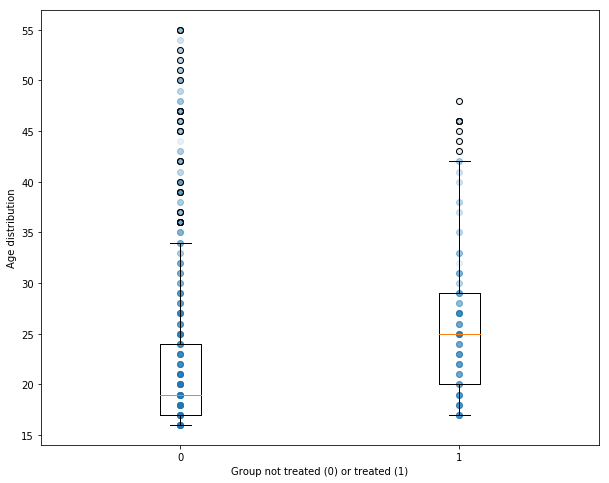

In [233]:
plt.figure(figsize=(10, 8))
plt.scatter(propensity_df.treat, propensity_df.age, alpha=0.1)

plt.xlabel('Group not treated (0) or treated (1)')
plt.ylabel('Age distribution')

plt.boxplot([control_df.age, treated_df.age], positions=[0, 1]);

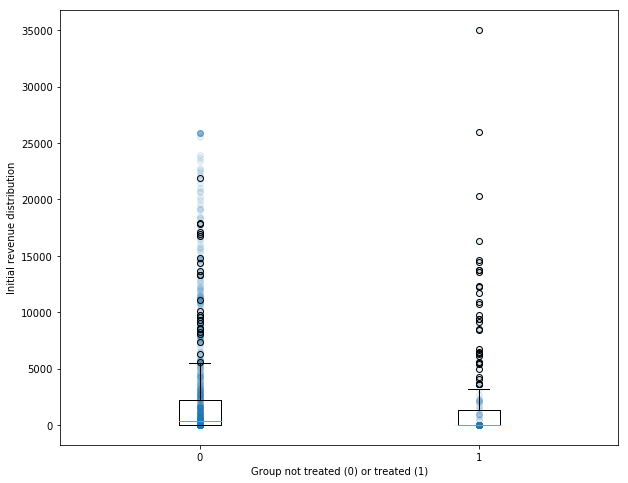

In [234]:
plt.figure(figsize=(10, 8))
plt.scatter(propensity_df.treat, propensity_df.re74, alpha=0.1)

plt.xlabel('Group not treated (0) or treated (1)')
plt.ylabel('Initial revenue distribution')

plt.boxplot([control_df.re74, treated_df.re74], positions=[0, 1]);

We can see the repartition is a bit better than previously. We however still have outliers.

In [235]:
propensity_diffs = []

# Calculating the average propensity diff between items
for k,v in matching_result.items():
    propensity_diffs.append(abs(propensity_df.propensity_score[propensity_df['id'] == k].values[0] - propensity_df.propensity_score[propensity_df['id'] == v].values[0]))

print('Extract of the 5 first differences:')
print(propensity_diffs[:5]) # We get the diff between the propensity score of two matched items
print ('\nAverage difference between the propensity scores: ' + str(np.mean(propensity_diffs)))

Extract of the 5 first differences:
[0.40352562676716797, 0.44659678837929306, 0.56225617862931943, 0.00062042421574304285, 0.55906576592378432]

Average difference between the propensity scores: 0.177896848295


We can see that the mean of the difference of all propensity score for each match is 17%. This may still be improved by taking differences between features into account.

### 5. Balancing the groups further

We have seen at the end of the previous question that there are still high inequalities of salaries between the two groups when considering the two years before the treatment. The dataset is *not* sufficiently balanced. Because of these inequalities, it is not possible to give sufficient conclusions as we still have very different profiles between the two groups.

We propose to take more parameters into account when building the graph.

In [256]:
# We start by normalizing data to avoid giving more importance to some features
treated_df['norm_black'] = (treated_df.black - treated_df.black.mean())/treated_df.black.std()
control_df['norm_black'] = (control_df.black - control_df.black.mean())/control_df.black.std()
treated_df['norm_propensity'] = (treated_df.propensity_score - treated_df.propensity_score.mean())/treated_df.propensity_score.std()
control_df['norm_propensity'] = (control_df.propensity_score - control_df.propensity_score.mean())/control_df.propensity_score.std()

treated_df.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,salary_evol74,salary_evol75,propensity_score,norm_black,norm_propensity
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,9930.0460,9930.0460,0.458039,0.429991,-0.471572
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,3595.8940,3595.8940,0.152098,-2.313057,-1.953906
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,24909.4500,24909.4500,0.750804,0.429991,0.946921
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,7506.1460,7506.1460,0.673895,0.429991,0.574286
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,289.7899,289.7899,0.670458,0.429991,0.557630


In [258]:
# We create a new graph
B = nx.Graph()

B.add_nodes_from(control_df.id.values, bipartite=0)
B.add_nodes_from(treated_df.id.values, bipartite=1)

edges = []
for treated_index, treated in treated_df.iterrows():
    for control_index, control in control_df.iterrows():
        edges.append((treated.id, control.id, -abs(treated.norm_propensity - control.norm_propensity) - abs(treated.norm_black - control.norm_black)))

B.add_weighted_edges_from(edges)

In [259]:
matching_result = max_weight_matching(B, True)

# Printing the 10 first matches
[(k,v) for k,v in matching_result.items()][:10]

[('PSID131', 'NSW150'),
 ('NSW21', 'PSID206'),
 ('PSID153', 'NSW145'),
 ('PSID173', 'NSW117'),
 ('PSID289', 'NSW180'),
 ('NSW62', 'PSID196'),
 ('NSW88', 'PSID333'),
 ('NSW112', 'PSID240'),
 ('PSID6', 'NSW159'),
 ('NSW67', 'PSID377')]

In [261]:
matched_list = list(matching_result.keys())
matched_df = propensity_df[propensity_df.id.isin(matched_list)]
treated_df = matched_df[matched_df.treat == 1]
control_df = matched_df[matched_df.treat == 0]

In [263]:
control_df.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,salary_evol74,salary_evol75,propensity_score
count,185.0,185.000000,185.000000,185.00000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,0.0,23.167568,9.864865,0.47027,0.102703,0.183784,0.675676,2268.386180,1670.138671,5828.584903,3560.198723,4158.446232,0.377482
std,0.0,9.337805,2.775692,0.50047,0.304394,0.388359,0.469392,4266.737051,2734.930726,6094.306306,6863.505650,6178.435981,0.234463
min,0.0,16.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-17135.750000,-13776.530000,0.036252
25%,0.0,17.000000,8.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,237.914000,0.000000,0.000000,0.183824
50%,0.0,19.000000,10.000000,0.00000,0.000000,0.000000,1.000000,336.993900,470.854800,4112.513000,2451.548000,2559.422000,0.239457
75%,0.0,24.000000,12.000000,1.00000,0.000000,0.000000,1.000000,2217.890000,1976.516000,8957.978000,7352.972000,7285.476600,0.650393
max,0.0,55.000000,17.000000,1.00000,1.000000,1.000000,1.000000,21918.320000,13776.530000,25564.670000,19993.640000,23885.347000,0.791987


# Q2 : Applied Machine Learning


## 2.1 Preparing Dataset

### Downloading and loading the data into notebook

In [2]:
data_all = fetch_20newsgroups(subset='all')
labels_all = data_all.target

### Vectorizing the text using TF-IDF features and default Scikit-learn functionalities

In [3]:
vectorizer = TfidfVectorizer()
vectors_all = vectorizer.fit_transform(data_all.data)
print('Dataset has ', vectors_all.shape[0] , ' examples with each examples having ', vectors_all.shape[1] , ' dimensions.')



Dataset has  18846  examples with each examples having  173762  dimensions.


An example of a newsitem:

In [5]:
print('The below example is labelled ', data_all.target_names[int(labels_all[420])] +'\n')
print(data_all.data[420])


The below example is labelled  sci.electronics

From: rdell@cbnewsf.cb.att.com (richard.b.dell)
Subject: Re: Fujitsu 8" HDD
Keywords: M2321K, M2322K, Fujitsu, Microdisk (-:
Organization: AT&T
Distribution: na
Lines: 15

In article <1993Apr17.204351.2256@aber.ac.uk> cjp1@aber.ac.uk (Christopher John Powell) writes:

[deletions]

>It appears to use two balanced-line connections, but what each connection
>corresponds to I know not. One connection is a 30-way IDC, the other a
>60-way IDC.

Sounds like it is an SMD interface to me, not being at work now
to actually count pins.  there are two varients, SMD  and
SMDC (I think), only minor differences between them.  Widely used
prior to the advent of SCSI for large drives (or all drives) on minis
(and mainframes(?) no experience on those).

Richard Dell



### Preparing the data splits

The training data set is 10% of the complete data where the total cross validation data is 90%. We have used scikit learn functionality for this but the same can also be achieved with few more lines of code by joining the labels with data, slicing using pandas/numpy and separating the labels afterwards.

In [6]:
vectors_cv, vector_test,labels_cv, labels_test = train_test_split( vectors_all, labels_all, test_size=0.1, random_state=42)

## 2.2 Cross Validation bench for finding the optimal parameter

This whole section needs to be run just once for finding the optimal params for andom Forest Classfier. Once found, we can directly jump to the next - Final model section.



As for cross-validation , we train each model thrice on a randomly chosen subset of the cross-val data. Notice that we have chosen the test_size as 0.11 in Shuffle split ( although called test_size this is the size of the cross_val dataset) because it ~115 of the 90% of the total data. Thus totalling to 9.9%~10% of the whole data. Otherwise, we would've got 9% of the actual data.

In [7]:
vectors_cv, vector_test,labels_cv, labels_test = train_test_split( vectors_all, labels_all, test_size=0.1, random_state=42)
cv = ShuffleSplit(n_splits=3, test_size=0.11, random_state=0)

### 2.2.1 Starting Cross-Validation

Starting with a wide inital guess of params

In [31]:
param_grid = {'max_depth': [20 ,30, 40, 50, 60, 70],
              'n_estimators': [5, 10, 15, 20, 30, 40, 50], }

The `%time` magical command allows to track the actual time taken to complete. `n_jobs` is an additional parameter 
to specify the number of cores to use to compute. Can be adjused as per user. 

In [32]:
clf =  GridSearchCV(RandomForestClassifier(random_state=0 , n_jobs = 8), param_grid , cv = cv)
%time clf.fit(vectors_cv, labels_cv)

Wall time: 14min 4s


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=0, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=8, oob_score=False, random_state=0,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [5, 10, 15, 20, 30, 40, 50], 'max_depth': [20, 30, 40, 50, 60, 70]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Obtaining a clean table for performance measures. 

In [33]:
results = pd.DataFrame(clf.cv_results_)

In [34]:
results

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,1.485441,0.165653,0.411707,0.487574,20,5,"{'n_estimators': 5, 'max_depth': 20}",42,0.424278,0.494824,0.426635,0.495545,0.384207,0.472353,0.081700,0.006569,0.019469,0.010767
1,2.117120,0.156975,0.509134,0.625590,20,10,"{'n_estimators': 10, 'max_depth': 20}",39,0.503241,0.623755,0.532115,0.634762,0.492045,0.618252,0.125276,0.010700,0.016881,0.006864
2,2.245847,0.151944,0.574150,0.701083,20,15,"{'n_estimators': 15, 'max_depth': 20}",35,0.575722,0.700865,0.591632,0.705516,0.555097,0.696868,0.084782,0.008742,0.014957,0.003534
3,2.826435,0.149638,0.624435,0.751114,20,20,"{'n_estimators': 20, 'max_depth': 20}",32,0.629935,0.754782,0.635828,0.751310,0.607543,0.747248,0.061035,0.012219,0.012185,0.003079
4,3.272358,0.140097,0.675309,0.806560,20,30,"{'n_estimators': 30, 'max_depth': 20}",26,0.674131,0.797956,0.676488,0.810273,0.675309,0.811452,0.071779,0.001413,0.000962,0.006103
5,4.004456,0.204342,0.709094,0.833923,20,40,"{'n_estimators': 40, 'max_depth': 20}",20,0.705952,0.829468,0.715380,0.839557,0.705952,0.832744,0.294505,0.049824,0.004445,0.004202
6,4.567097,0.241132,0.725594,0.850585,20,50,"{'n_estimators': 50, 'max_depth': 20}",19,0.723630,0.844864,0.723041,0.854232,0.730112,0.852660,0.138987,0.003589,0.003204,0.004096
7,1.885443,0.161891,0.465527,0.603249,30,5,"{'n_estimators': 5, 'max_depth': 30}",41,0.469063,0.609342,0.467885,0.599515,0.459635,0.600891,0.044893,0.004418,0.004194,0.004345
8,2.853358,0.161247,0.576704,0.747773,30,10,"{'n_estimators': 10, 'max_depth': 30}",34,0.577490,0.746004,0.578079,0.749017,0.574543,0.748297,0.065387,0.009129,0.001547,0.001285
9,2.993183,0.137166,0.641917,0.814968,30,15,"{'n_estimators': 15, 'max_depth': 30}",30,0.626400,0.811386,0.654685,0.812959,0.644667,0.820558,0.172783,0.002748,0.011710,0.004005


## 2.2.2 Observation for further experiment

We notice that in the above experiment the best results are obtained for the highest value of parameters thus suggesting to try even higher values. Using a higher but narrower range this time. 


In [38]:
param_grid2= {'max_depth': [60, 70, 80,90,100],
              'n_estimators': [40, 50, 60,70,80,90]}
clf2 = GridSearchCV(RandomForestClassifier(random_state=0 , n_jobs = 8), param_grid2 , cv = cv)
%time clf2.fit(vectors_cv, labels_cv)

Wall time: 32min 38s


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=0, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=8, oob_score=False, random_state=0,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [40, 50, 60, 70, 80, 90], 'max_depth': [60, 70, 80, 90, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [39]:
results2 = pd.DataFrame(clf2.cv_results_)

In [40]:
results2

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,10.025961,0.213422,0.792575,0.984954,60,40,"{'n_estimators': 40, 'max_depth': 60}",30,0.802004,0.986832,0.786093,0.982835,0.789629,0.985194,0.599586,0.065213,0.006821,0.001640
1,11.211836,0.281760,0.804164,0.987552,60,50,"{'n_estimators': 50, 'max_depth': 60}",27,0.806718,0.988994,0.799057,0.985718,0.806718,0.987945,0.268820,0.070085,0.003611,0.001366
2,13.134366,0.379295,0.812610,0.988753,60,60,"{'n_estimators': 60, 'max_depth': 60}",21,0.814378,0.988994,0.809664,0.987618,0.813789,0.989649,0.494110,0.003539,0.002097,0.000846
3,15.383046,0.319809,0.819093,0.989780,60,70,"{'n_estimators': 70, 'max_depth': 60}",18,0.823217,0.990304,0.817914,0.988863,0.816146,0.990173,0.506953,0.063684,0.003005,0.000651
4,17.452258,0.319094,0.826164,0.990719,60,80,"{'n_estimators': 80, 'max_depth': 60}",14,0.827932,0.990632,0.822039,0.990042,0.828521,0.991483,0.430513,0.059957,0.002927,0.000592
5,17.555641,0.315719,0.831664,0.991549,60,90,"{'n_estimators': 90, 'max_depth': 60}",9,0.836181,0.992204,0.824985,0.990501,0.833824,0.991942,0.572023,0.053112,0.004819,0.000749
6,11.490247,0.200874,0.797682,0.992444,70,40,"{'n_estimators': 40, 'max_depth': 70}",28,0.789629,0.993449,0.797879,0.992859,0.805539,0.991025,0.057396,0.053809,0.006497,0.001032
7,13.546562,0.249444,0.807307,0.993470,70,50,"{'n_estimators': 50, 'max_depth': 70}",24,0.800236,0.994693,0.806718,0.993776,0.814968,0.991942,0.243048,0.022790,0.006029,0.001144
8,17.747160,0.345111,0.818503,0.994082,70,60,"{'n_estimators': 60, 'max_depth': 70}",19,0.813200,0.995086,0.818503,0.994169,0.823807,0.992990,0.877132,0.073292,0.004330,0.000858
9,19.579997,0.281938,0.825378,0.994759,70,70,"{'n_estimators': 70, 'max_depth': 70}",15,0.823217,0.995480,0.825575,0.994824,0.827342,0.993973,1.045243,0.069548,0.001690,0.000617


### 2.2.3 : Even further experiment

The same problem repeats again. Using even higher values but with small range now. 

In [41]:
param_grid3= {'max_depth': [90,100, 110, 120],
              'n_estimators': [80,90, 100 , 110]}
clf3 = GridSearchCV(RandomForestClassifier(random_state=0 , n_jobs = 8), param_grid3 , cv = cv)
%time clf3.fit(vectors_cv, labels_cv)

Wall time: 28min 55s


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=0, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=8, oob_score=False, random_state=0,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [80, 90, 100, 110], 'max_depth': [90, 100, 110, 120]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [43]:
results3 = pd.DataFrame(clf3.cv_results_)
results3

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,24.795837,0.411968,0.833039,0.998733,90,80,"{'n_estimators': 80, 'max_depth': 90}",16,0.833235,0.998559,0.826164,0.998755,0.839717,0.998886,0.518043,0.049680,0.005535,1.346177e-04
1,28.082280,0.373256,0.834414,0.998843,90,90,"{'n_estimators': 90, 'max_depth': 90}",14,0.838539,0.998690,0.823807,0.998886,0.840896,0.998952,1.451036,0.141791,0.007562,1.113518e-04
2,30.292976,0.373348,0.836574,0.998843,90,100,"{'n_estimators': 100, 'max_depth': 90}",12,0.836181,0.998886,0.830289,0.998821,0.843253,0.998821,1.037137,0.053993,0.005300,3.088342e-05
3,30.470957,0.402448,0.839128,0.998952,90,110,"{'n_estimators': 110, 'max_depth': 90}",10,0.842074,0.999017,0.830289,0.998886,0.845021,0.998952,0.270371,0.101395,0.006365,5.349165e-05
4,25.376795,0.362958,0.835985,0.999301,100,80,"{'n_estimators': 80, 'max_depth': 100}",13,0.840306,0.999345,0.828521,0.999017,0.839128,0.999541,1.018903,0.107333,0.005300,2.161839e-04
5,28.527824,0.297910,0.843449,0.999345,100,90,"{'n_estimators': 90, 'max_depth': 100}",6,0.845610,0.999214,0.838539,0.999214,0.846199,0.999607,0.643824,0.050777,0.003481,1.853005e-04
6,31.149265,0.459654,0.846003,0.999323,100,100,"{'n_estimators': 100, 'max_depth': 100}",3,0.849735,0.999214,0.839717,0.999148,0.848556,0.999607,0.670212,0.113889,0.004471,2.025161e-04
7,38.339701,0.515438,0.848753,0.999476,100,110,"{'n_estimators': 110, 'max_depth': 100}",2,0.849735,0.999410,0.845610,0.999279,0.850913,0.999738,1.447922,0.129968,0.002274,1.928669e-04
8,30.370284,0.348293,0.834021,0.999716,110,80,"{'n_estimators': 80, 'max_depth': 110}",15,0.828521,0.999672,0.834414,0.999672,0.839128,0.999803,0.400752,0.106480,0.004339,6.176684e-05
9,32.558777,0.388287,0.838342,0.999694,110,90,"{'n_estimators': 90, 'max_depth': 110}",11,0.834414,0.999672,0.837949,0.999672,0.842664,0.999738,1.728720,0.071644,0.003379,3.088342e-05


### 2.2.4 : The final step

The same problem still repeats but since the gap in best estimators is much smaller now, this means this step should 
find the optimal parameters now. 

In [44]:
param_grid4= {'max_depth': [120,  140, 160],
              'n_estimators': [100 ,120, 140]}
clf4 = GridSearchCV(RandomForestClassifier(random_state=0 , n_jobs = 8), param_grid4 , cv = cv)
%time clf4.fit(vectors_cv, labels_cv)

Wall time: 24min 38s


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=0, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=8, oob_score=False, random_state=0,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 120, 140], 'max_depth': [120, 140, 160]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [45]:
results4 = pd.DataFrame(clf4.cv_results_)
results4


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,36.849772,0.458792,0.844824,0.999913,120,100,"{'n_estimators': 100, 'max_depth': 120}",9,0.845610,0.999934,0.836771,0.999934,0.852092,0.999869,0.495320,0.178278,0.006279,3.088342e-05
1,43.615133,0.452934,0.849735,0.999869,120,120,"{'n_estimators': 120, 'max_depth': 120}",6,0.855038,0.999869,0.839717,0.999869,0.854449,0.999869,0.231218,0.106040,0.007088,0.000000e+00
2,48.590655,0.535677,0.851306,0.999847,120,140,"{'n_estimators': 140, 'max_depth': 120}",4,0.856806,0.999869,0.843253,0.999803,0.853860,0.999869,0.553527,0.153332,0.005820,3.088342e-05
3,39.536621,0.467547,0.848949,0.999934,140,100,"{'n_estimators': 100, 'max_depth': 140}",7,0.852092,0.999934,0.846788,0.999934,0.847967,0.999934,0.390505,0.025862,0.002274,1.110223e-16
4,51.254158,0.654150,0.851699,0.999934,140,120,"{'n_estimators': 120, 'max_depth': 140}",3,0.857395,0.999934,0.848556,0.999934,0.849146,0.999934,1.298463,0.244252,0.004035,1.110223e-16
5,57.783405,0.574911,0.855431,0.999934,140,140,"{'n_estimators': 140, 'max_depth': 140}",1,0.855628,0.999934,0.853270,0.999934,0.857395,0.999934,1.499260,0.167357,0.001690,1.110223e-16
6,41.718227,0.460633,0.846003,0.999934,160,100,"{'n_estimators': 100, 'max_depth': 160}",8,0.848556,0.999934,0.843253,0.999934,0.846199,0.999934,0.664722,0.061454,0.002170,1.110223e-16
7,56.259005,0.750183,0.850913,0.999934,160,120,"{'n_estimators': 120, 'max_depth': 160}",5,0.852681,0.999934,0.846788,0.999934,0.853270,0.999934,2.127975,0.042717,0.002927,1.110223e-16
8,62.502033,0.593865,0.851896,0.999934,160,140,"{'n_estimators': 140, 'max_depth': 160}",2,0.852681,0.999934,0.845610,0.999934,0.857395,0.999934,4.680417,0.111873,0.004843,1.110223e-16


We observe that now the best performance is found at intermediate values suggesting good parameters to be found.
We can still optimize the values in smaller range but this is not worth the effort since the change from the peak performance
around the optimal paramater is too slow that suggests that any such optimization is not fruitful for the effort.

## 2.3 : The Final Model

In case the cross validation is perfomed we can load the model directly with `model = clf4.best_estimator_` 
Otherwise, we can train the model using the best parameters in the 2.2

In [8]:
# Noting the best parameter setting to be n_estimators = 140 and max_depth = 140. We can directly train 
# the best model for next time.

model = RandomForestClassifier(n_jobs=8, random_state=0 , n_estimators = 140 , max_depth = 140)

vectors_train, vector_val,labels_train, labels_val = train_test_split(vectors_cv, labels_cv, test_size=0.11, random_state=42)
model.fit(vectors_train,labels_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=140, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=140, n_jobs=8, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

## 2.4 : Evaluation Criterion : Accuracy and Confusion Matrix

### 2.4.1 : Different Accuracies:

It is interesting to note that even though the validation dataset is not use for training, the accuracy on val is certainly 
consistently a bit higher than the testing dataset which is an artefact of the fact that we are using it to indirectly train by 
choosing the best parameters through it.

In [9]:
print('Training Accuracy', np.round(model.score(vectors_train, labels_train)*100,3))
print('Validation set Accuracy', np.round(model.score(vector_val,labels_val)*100,3))
print('Test Accuracy', np.round(model.score(vector_test,labels_test)*100,3))

Training Accuracy 99.993
Validation set Accuracy 85.423
Test Accuracy 84.297


### 2.4.2 : Confusion Matrix :


In [10]:
labels_pred =model.predict(vector_test)
conf_arr = confusion_matrix(labels_test,labels_pred)


([<matplotlib.axis.YTick at 0x622fce02b0>,
 <a list of 20 Text yticklabel objects>)

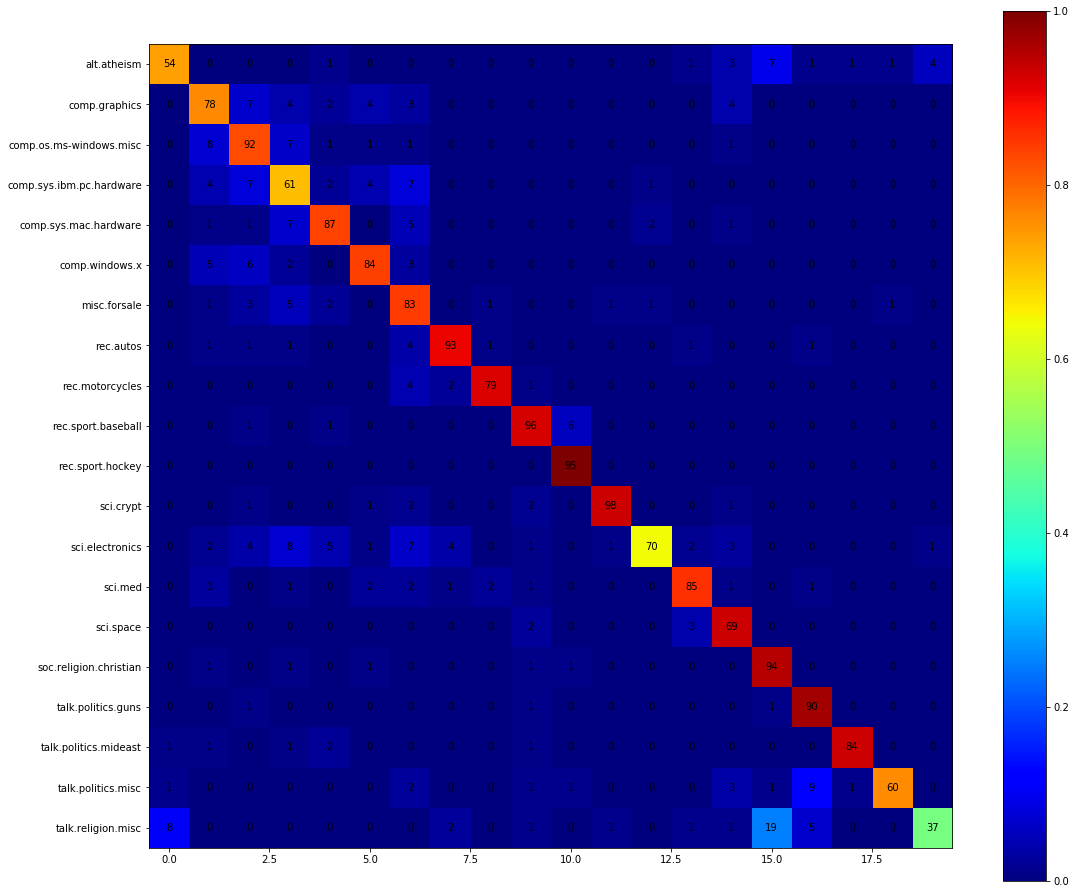

In [17]:
#Plotting the Confuion matrix. 
#Code : https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix (slightly tweaked)

norm_conf = []
for i in conf_arr:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        tmp_arr.append(float(j)/float(a))
    norm_conf.append(tmp_arr)
    
    
fig = plt.figure(figsize=(18, 16))
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_conf), cmap=plt.cm.jet, 
                interpolation='nearest')

width, height = conf_arr.shape


    
for x in range(width):
    for y in range(height):
        ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

cb = fig.colorbar(res)
alphabet = data_all.target_names
plt.yticks(range(height), alphabet[:height])


The model classify pretty well most of the categories.  
The most category that the classifier missclassify is the 19 : `talk.religion.misc`

## 2.5 : Inspecting feature importances : 

The importances of each word in classification stored in a sorted order

In [11]:
imp = model.feature_importances_
sort_imp_tuple = [i[0] for i in sorted(enumerate(imp), key=lambda x:x[1])]

A list of all words in the same order as in TF.IDF vector

In [12]:
diction = vectorizer.vocabulary_
sorted_x = sorted(diction.items(), key=operator.itemgetter(1))
words = [i[0] for i in sorted_x]

Choosing the top 5 words to inspect their frequency distribution across classes. 

In [14]:
how_many_inspect = 5
words_important = [words[sort_imp_tuple[i]] for i in range(len(words)-how_many_inspect,len(words))]
print('The most distinguishable words are')
print(words_important[::-1])

The most distinguishable words are
['sale', 'windows', 'bike', 'space', 'dod']


For each of the top word finding the class it belongs to the most number of times qunatitatively

In [15]:
for w in words_important[::-1]:
    freq_dict = dict()
    for doc in range(vectors_all.shape[0]): #len(vectors_all.shape[0])):
        if(float(vectors_all[doc,diction[w]]) > 0.01):
            if(data_all.target_names[labels_all[doc]] not in freq_dict):
                freq_dict[data_all.target_names[labels_all[doc]]] = 0
            freq_dict[data_all.target_names[labels_all[doc]]] += 1
    print(' The most frequent category for the word',w, 'is', max(freq_dict, key=freq_dict.get), ' with ' ,
      100*np.round(freq_dict[max(freq_dict, key=freq_dict.get)]/sum(freq_dict.values()),4) ,' percent occurance in that class' )

 The most frequent category for the word sale is misc.forsale  with  74.49  percent occurance in that class
 The most frequent category for the word windows is comp.os.ms-windows.misc  with  51.2  percent occurance in that class
 The most frequent category for the word bike is rec.motorcycles  with  94.99  percent occurance in that class
 The most frequent category for the word space is sci.space  with  52.58  percent occurance in that class
 The most frequent category for the word dod is rec.motorcycles  with  83.36  percent occurance in that class


# Discussion

- We find that TF-IDF features along with cross validated random forests do a good job at classifying in a 20-way classification
achieving ~85% accuracy where by random guess it would've been only 5%. 
- The model is also trained reasonably fast in a matter of few seconds expecially parallelizing over `n_jobs`
- The feature_importance method provides useful insight into the TF-IDF features and classification model . For example: intuitively we would expect `sale` to be a strong indicator of the class `misc.forsale` which turns out to be true
- The case of `windows` being used half of the times in context of `comp.os.ms-windows.misc` is surprising at first but then reasonably expected.
- The other three words `bike`, `space` and `dod` are also intuitively verifired. Thus TF-IDF features resemble closely our expectations. 
- The confusion matrix plot indicates `talk.religion.misc` to be the most confusing category which makes sense for it being a miscallaneous one. 
- Also, comp.xxx are easy to predict given the technical words which again shows up in the classification.

**Overall, for the simplicity of TF-IDF features in comparaison to other `word2vec` and NLP DL models such as RNN-LSTM, the fact that they can perform so good at text classification tasks shows the power of simple intuition on small datasets!**